<a href="https://colab.research.google.com/github/Geek-a-Byte/thesis/blob/main/FL_practise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip '/content/trainingSet.zip'

In [ ]:
!pip install tensorflow==2.2.0
!sudo pip3 install keras

In [ ]:
import numpy as np
import random
import cv2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

## **Reading and preprocessing MNIST data set**

On line 9, each image will be read from disk as grey scale and then flattened. The flattening step is import because we will be using a MLP network architecture later on. To obtain the class label of an image, we split its path string on line 11. Hope you noticed we also scaled the image to [0, 1] on line 13 to douse the impact of varying pixel brightness.

In [ ]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2] # 0 1 2 3 4 5 6 7 8 9
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print(label);
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    return data, labels

## **Federated Members (clients) as Data Shards**

In the real world implementation of FL, each federated member will have its own data coupled with it in isolation. Remember the aim of FL is to ship models to data and not the other way around. The shard creation step here only happens in experiments. I will share the training set into 10 shards, one per client. I wrote a function called create_clients to achieve this.

On line 13, I created a list of client names using the prefix (initials). On line 16–20, I zipped the data and label lists then randomised the resulting tuple list. Finally I created shards from the tuple list based on the desired number of clients (num_clients) on line 21. On line 26, a dictionary containing each client’s name as key and their data share as value was returned. Let’s now go ahead and apply this function to our training data set.

In [ ]:
def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}

## **Processing and batching clients’ and test data**

Next is to process each of the client’s data into tensorflow data set and batch them. To simplify this step and avoid repetition, I encapsulated the procedure into a small function named batch_data.

I trust you remember that each of the client data sets came out as a (data, label) tuple list from create_clients. On line 9 above, I split the tuple into separate data and label lists. I then made a shuffled and batched tensorflow dataset object off these lists.

In [ ]:
# Function for preparing client data for training
def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

## **Creating the Multi Layer Perceptron (MLP) model**

One thing I didn't mention in the introduction section is that FL is mostly suited for parameterized learning — all types of neural networks. Machine learning techniques such as KNN or it likes that merely store training data while learning might not benefit from FL. I’m creating a 3-layer MLP to serve as the model for our classification task. I hope you still remember all those Keras modules we imported earlier, this is where they fit in.

In [ ]:
# Model architecture: MLP
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

## **Model Aggregation (Federated Averaging)**
All I have done up to this point was pretty much standard as per deep learning pipeline. Of course with the exception of the data partitioning or client creation bit. I will now move on to Federated Averaging ( the vanilla algorithm for FL) which is the whole point of the this tutorial. The data I’m using is horizontally partitioned, so I will simply be doing component wise parameter averaging which will be weighed based on the proportion of data points contributed by each participating client. Here’s the federated averaging equation I’m using, it comes one of the pioneering works on federated learning [2].
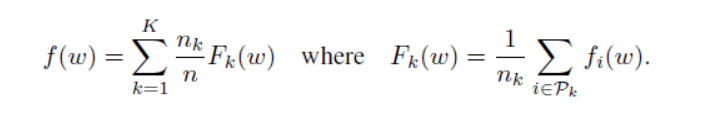

Don’t let the complex mathematical notations in the equation fool you, this is a pretty straight forward computation. On the right hand side, we are estimating the weight parameters for each client based on the loss values recorded across every data point they trained with. On the left, we scaled each of those parameters and sum them all component-wise.

Below I have encapsulated this procedure into three simple functions.

In [ ]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count

def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


'''
I ran 100 global training loops as stipulated by the comms_round and on line 48 
tested the trained global model after each communication round our test data. 
Here is the snippet for the test logic:
'''

def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

## **Creating train-test split**

> A couple of steps took place in this snippet. We applied the load function defined in the previous code block to obtain the list of images (now in numpy arrays) and label lists. After that, we used the LabelBinarizer object from sklearn to 1-hot-encode the labels. Going forward, rather than having the label for digit 1 as number 1, it will now have the form[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]. With this labelling style, we’ll be able to use the cross-entropy loss in Tensorflow as our model’s loss function. Alternatively, I could have left the labels as it was and use the sparse-categorical-entropy loss instead. Finally, I used the sklearn’s train_test_split object to split the data into a train/test with ratio 9:1



In [ ]:
#declear path to your mnist data folder
img_path = '/content/trainingSet/'

#get the path list using the path object
image_paths = list(paths.list_images(img_path))

#apply our function
image_list, label_list = load(image_paths, verbose=10000)

#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(image_list, 
                                                    label_list, 
                                                    test_size=0.1, 
                                                    random_state=42)

#create clients
clients = create_clients(X_train, y_train, num_clients=10, initial='client')

'''
While applying this function batch_data, I will process the test set as well and keep it aside for later use.
'''
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

'''
To build a new model, the build method will be invoked. 
It requires the input data’s shape and the number of classes as arguments. 
With MNIST, the shape parameter will be 28*28*1 = 784,while the number of classes will be 10.
Now is the time to define an optimizer, loss function and metrics to compile our models with later on.
'''
comms_round = 100
    
#create optimizer
lr = 0.01 
loss='categorical_crossentropy'
metrics = ['accuracy'] # f1_score, precision_score
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               ) 

'''
SGD is my default optimizer except when I have a reason not to use it. 
The loss function is categorical_crossentropy. 
And finally, the metric I will be using is accuracy. 
But something looks strange in the decay argument. 
What’s comms_round? 
It’s simply the number global epochs (aggregations) I will be running during training. 
So rather than decaying the learning rate with respect to the number of local epochs as you might be familiar with, 
here I want to decay with respect to the number of global aggregation. 
This is obviously an hyper parameter selection choice, 
but I found it to work pretty well while experimenting.
'''



## **Federated Model Training**

The training logic has two main loops, the outer loop is for the global iteration, the inner is for iterating through client’s local training. There’s an implicit third one though, it accounts for the local epochs and will be taken care of by the epochs argument in our model.fit method.

Starting out I built the global model with input shape of (784,) and number of classes as 10 — lines 2–3. I then stepped into the outer loop. First obtaining the initialised weights of the global model on line 9. Lines 15 and 16 shuffles the clients dictionary order to ensure randomness. From there, I started iterating through client training.

For each client, I created a new model object, compiled it and set it’s initialisation weights to the current parameters of the global model — lines 20–27. The local model (client) was then trained for one epoch. After training, the new weights were scaled and appended to the scaled_local_weight_list on line 35. That was it for local training.

Moving back into the outer loop on line 41, I summed up all the scaled local trained weights (of course by components) and updated the global model to this new aggregate. That ends a full global training epoch.

In [ ]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(784, 10)
        
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
        
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        #fit local model with client's data
        tf.autograph.experimental.do_not_convert(local_model.fit(clients_batched[client], epochs=1, verbose=0))
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)

    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
    
 

comm_round: 0 | global_acc: 88.476% | global_loss: 1.6665740013122559
comm_round: 1 | global_acc: 90.738% | global_loss: 1.6157482862472534
comm_round: 2 | global_acc: 91.524% | global_loss: 1.5961037874221802
comm_round: 3 | global_acc: 92.214% | global_loss: 1.5862112045288086
comm_round: 4 | global_acc: 92.452% | global_loss: 1.5777422189712524
comm_round: 5 | global_acc: 93.071% | global_loss: 1.570860743522644
comm_round: 6 | global_acc: 93.333% | global_loss: 1.5650556087493896
comm_round: 7 | global_acc: 93.881% | global_loss: 1.5594133138656616
comm_round: 8 | global_acc: 94.095% | global_loss: 1.5569168329238892
comm_round: 9 | global_acc: 94.381% | global_loss: 1.5527793169021606
comm_round: 10 | global_acc: 94.667% | global_loss: 1.5495015382766724
comm_round: 11 | global_acc: 94.929% | global_loss: 1.547296166419983
comm_round: 12 | global_acc: 94.976% | global_loss: 1.5444680452346802
comm_round: 13 | global_acc: 94.976% | global_loss: 1.5427590608596802
comm_round: 14 | g

Results
With 10 clients each running 1 local epoch on top of 100 global communication rounds, here is the truncated test result:

## **SGD Vs Federated Averaging**

Yes, our FL model results are great, 96.5% test accuracy after 100 communication rounds. But how does it compare to a standard SGD model trained on the same data set? To find out, I’ll train a single 3-layer MLP model (rather 10 as we did in FL) on the combined training data. Remember the combined data was our training data prior to partitioning.

To ensure an equal playing ground, I will retain every hyper parameter used for the FL training except the batch size. Rather than using 32 , our SGD’s batch size will be 320. With this setting, we are sure that the SGD model would see exactly the same number of training samples per epoch as the global model did per communication round in FL.



In [ ]:
SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(784, 10) 

SGD_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)

# fit the SGD training data to model
_ = SGD_model.fit(SGD_dataset, epochs=100, verbose=0)

#test the SGD global model and print out metrics
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)   

comm_round: 1 | global_acc: 94.857% | global_loss: 1.5432435274124146


There you have it, a 94.5% test accuracy for the SGD model after 100 epochs. Isn’t it surprising that the FL performed a little better than its SGD counterpart with this data set? I warn you not to get too excited about this though. These kind of results are not likely in real world scenario. Yeah! Real world federated data held by clients are mostly NON independent and identically distributed (IID).